In [1]:
#importing libraries
import pandas as pd
import matplotlib
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import statsmodels
from statsmodels.stats import multitest
import statistics
from math import sqrt
from statsmodels.stats.power import TTestIndPower
from SigProfilerExtractor import sigpro as sig
import os.path
import glob
import fnmatch
import os
import shutil
from SigProfilerMatrixGenerator.scripts import CNVMatrixGenerator as scna
from SigProfilerMatrixGenerator.scripts import SigProfilerMatrixGeneratorFunc as matGen
from SigProfilerAssignment import Analyzer as Analyze

#display plots in notebook
%matplotlib inline

#default figure settings
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.autolayout"] = True

def listdir(dirname, pattern="*"):
    return fnmatch.filter(os.listdir(dirname), pattern)

#run this only once at the start
#from SigProfilerMatrixGenerator import install as genInstall
#genInstall.install('GRCh37')

for x in ["TL-22-P4ACNIE3_T_DSQ1", "TL-22-JICYR8PP_T_DSQ1", "TL-22-DHERTUS6_T_DSQ1", "TL-22-86QRKCES_T_DSQ1"]:
    print(x)
    current_vcf_path = "/intelpool/UTUCproject/DNA_data/COSMIC_analyses/{}".format(x)
    matGen.SigProfilerMatrixGeneratorFunc(x, 'GRCh37', current_vcf_path)
    current_ID83_path = "/intelpool/UTUCproject/DNA_data/COSMIC_analyses/{}/output/ID/{}.ID83.all".format(x,x)
    current_extractor_path = "/intelpool/UTUCproject/DNA_data/COSMIC_analyses/{}".format(x)
    sig.sigProfilerExtractor("matrix", current_extractor_path, current_ID83_path, reference_genome="GRCh37", minimum_signatures=1, maximum_signatures=1)
    

for x in ["TL-22-P4ACNIE3_T_DSQ1", "TL-22-JICYR8PP_T_DSQ1", "TL-22-DHERTUS6_T_DSQ1", "TL-22-86QRKCES_T_DSQ1"]:
    print(x)
    Analyze.cosmic_fit(samples="/intelpool/UTUCproject/DNA_data/COSMIC_analyses/{}/".format(x,x), 
                   output="/intelpool/UTUCproject/DNA_data/COSMIC_analyses/{}/Assigner_run".format(x),
                   input_type="vcf",
                   context_type="96",
                   genome_build="GRCh37", exclude_signature_subgroups = ["'Artifact_signatures'"])
     

In [2]:
pt_names = listdir("/intelpool/UTUCproject/DNA_data/COSMIC_analyses/", "*TL*_T*")
keep_list = []
GATK_final_dict_ID = {}

for x in range(0, len(pt_names)):
    #ID
    ID83_data = pd.read_csv("/intelpool/UTUCproject/DNA_data/COSMIC_analyses/{}/ID83/Suggested_Solution/COSMIC_ID83_Decomposed_Solution/De_Novo_map_to_COSMIC_ID83.csv".format(pt_names[x]), sep = ",").apply(pd.to_numeric, errors = "ignore").loc[:, " Global NMF Signatures"]
    current_data = ID83_data[0].split("(")
    first_percent_list = []
    first_ID_list = [ID83_data[0].split("(")[0]]
    for y in range(0, len(current_data)):
        first_percent_list.append(current_data[y].split(")")[0])
        if (y>0):
            first_ID_list.append(current_data[y].split(")")[1])
            
    first_percent_list.pop(0)
    first_ID_list = list(filter(None, first_ID_list))
    final_ID_list = [q.split(" ")[-2] for q in first_ID_list] 
    print()
    print("final_ID_list:", final_ID_list)
    final_percent_list = [c.split("%")[0] for c in first_percent_list]
    print("final_percent_list:", final_percent_list)
    
    if "Signature" not in final_ID_list:
        keep_list.append(pt_names[x])
        GATK_final_dict_ID[pt_names[x]]= pd.DataFrame(columns = final_ID_list)
        GATK_final_dict_ID[pt_names[x]].loc[pt_names[x]] = final_percent_list
    
GATK_final_df_ID = pd.concat(GATK_final_dict_ID.values(),keys=GATK_final_dict_ID.keys()).apply(pd.to_numeric, errors = "coerce")
GATK_final_df_ID.index = keep_list
GATK_final_df_ID = GATK_final_df_ID.fillna(0)
GATK_final_df_ID["ID1/2"] = GATK_final_df_ID["ID1"] + GATK_final_df_ID["ID2"]
GATK_final_df_ID.drop(["ID1", "ID2"], axis = 1, inplace = True)
GATK_final_df_ID = GATK_final_df_ID[["ID1/2", "ID7"]]
GATK_final_df_ID = GATK_final_df_ID.loc[["TL-22-P4ACNIE3_T_DSQ1", "TL-22-JICYR8PP_T_DSQ1", "TL-22-DHERTUS6_T_DSQ1", "TL-22-86QRKCES_T_DSQ1"]]



final_ID_list: ['ID1', 'ID2', 'ID7']
final_percent_list: ['11.22', '52.68', '36.10']

final_ID_list: ['ID1', 'ID2', 'ID7']
final_percent_list: ['9.92', '58.38', '31.70']

final_ID_list: ['ID1', 'ID2', 'ID7']
final_percent_list: ['10.46', '37.66', '51.88']

final_ID_list: ['ID2', 'ID7']
final_percent_list: ['62.36', '37.64']


In [3]:
GATK_final_dict_SBS = {}

for x in ["TL-22-P4ACNIE3_T_DSQ1", "TL-22-JICYR8PP_T_DSQ1", "TL-22-DHERTUS6_T_DSQ1", "TL-22-86QRKCES_T_DSQ1"]:
    GATK_final_dict_SBS[x] = pd.read_csv("/intelpool/UTUCproject/DNA_data/COSMIC_analyses/{}/Assigner_run/Assignment_Solution/Activities/Assignment_Solution_Activities.txt".format(x), sep = "\t", index_col = 0)

GATK_final_df_SBS = pd.concat(GATK_final_dict_SBS.values(),keys=GATK_final_dict_SBS.keys()).apply(pd.to_numeric, errors = "coerce")
GATK_final_df_SBS.index = ["TL-22-P4ACNIE3_T_DSQ1", "TL-22-JICYR8PP_T_DSQ1", "TL-22-DHERTUS6_T_DSQ1", "TL-22-86QRKCES_T_DSQ1"]
#keeping only columns with data
GATK_final_df_SBS = GATK_final_df_SBS[["SBS1", "SBS5", "SBS6", "SBS29", "SBS18", "SBS52"]]
GATK_final_df_SBS["SBS1/5"] = GATK_final_df_SBS["SBS1"] + GATK_final_df_SBS["SBS5"]
GATK_final_df_SBS["SBS18/29"] = GATK_final_df_SBS["SBS18"] + GATK_final_df_SBS["SBS29"]
#SBS52 is an antrifact signature
GATK_final_df_SBS.drop(["SBS1", "SBS5", "SBS18", "SBS29", "SBS52"], axis = 1, inplace = True)
GATK_final_df_SBS = GATK_final_df_SBS[["SBS1/5", "SBS6", "SBS18/29"]]


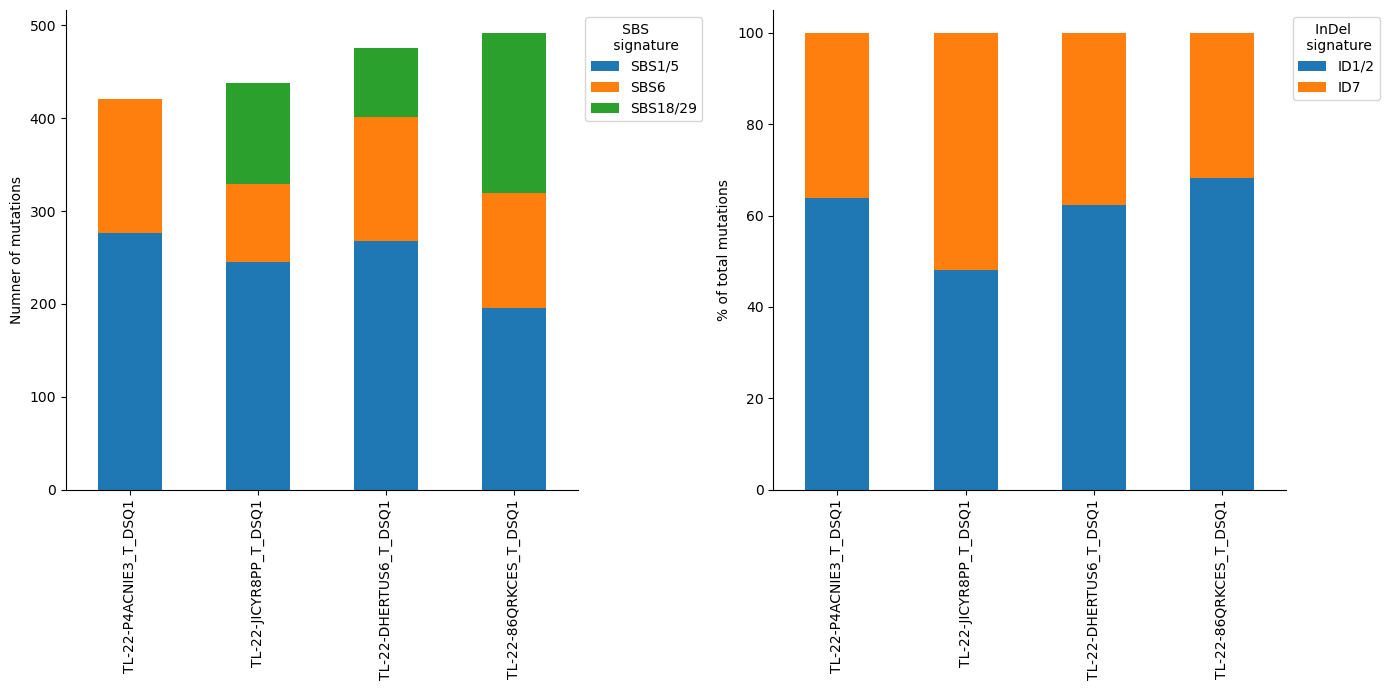

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
GATK_final_df_SBS.plot(kind = "bar", stacked = True, ax = ax[0])
ax[0].set_ylabel("Numner of mutations")
ax[0].legend(bbox_to_anchor=(1.0, 1.0), title = "   SBS \n signature")
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

GATK_final_df_ID.plot(kind = "bar", stacked = True, ax = ax[1])
ax[1].set_ylabel("% of total mutations")
ax[1].legend(bbox_to_anchor=(1.0, 1.0), title = "   InDel \n signature")
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.rcParams['savefig.bbox'] = 'tight'
plt.savefig('PT1_SBSandIDCOSMIC.png')

In [5]:
ordered_patient_list = ["TL-22-P4ACNIE3_T_RSQ1", "TL-22-JICYR8PP_T_RSQ1", "TL-22-DHERTUS6_T_RSQ1", "TL-22-86QRKCES_T_RSQ1", "TL-22-354IF4A9_T_RSQ1", "TL-22-RVHYDX4F_T_RSQ1", "TL-22-TMY85WNT_T_RSQ1", "TL-22-KXMGA3WE_T_RSQ1", "TL-22-BK3DDUYG_T_RSQ1", "TL-22-PKA8ZUD2_T_RSQ1", "TL-22-SA4HH23W_T_RSQ1"]
current_RNAdict = {}

for x in ordered_patient_list:
    genes_list = pd.read_csv("/intelpool/UTUCproject/RNA_data/{}/{}.genes.results".format(x,x), sep = "\t")["gene_id"]
    current_RNAdict[x] = pd.DataFrame(pd.read_csv("/intelpool/UTUCproject/RNA_data/{}/{}.genes.results".format(x,x), sep = "\t")["FPKM"]).transpose()
    
RNA_heatmapdf = pd.concat(current_RNAdict.values(),keys=current_RNAdict.keys()).apply(pd.to_numeric, errors = "ignore")
RNA_heatmapdf.index = ordered_patient_list
RNA_heatmapdf.columns = genes_list
RNA_heatmapdf = RNA_heatmapdf.transpose()

RNA_heatmapdf.to_csv("FullRNAUTUC_FPKMs.csv", index = True, header = True)
RNA_heatmapdf.to_csv("FullRNAUTUC_FPKMs.txt", sep = "\t", index = True, header = True)
#log10 with pseudocount
RNA_heatmapdf_LOG10 = np.log10(RNA_heatmapdf + 1)


In [102]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(RNA_heatmapdf_LOG10.transpose())
kmeans.labels_

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f21ce1eea70>
Traceback (most recent call last):
  File "/home/rin/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/rin/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/rin/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/rin/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


array([2, 3, 2, 2, 0, 0, 1, 1, 1, 4, 4], dtype=int32)

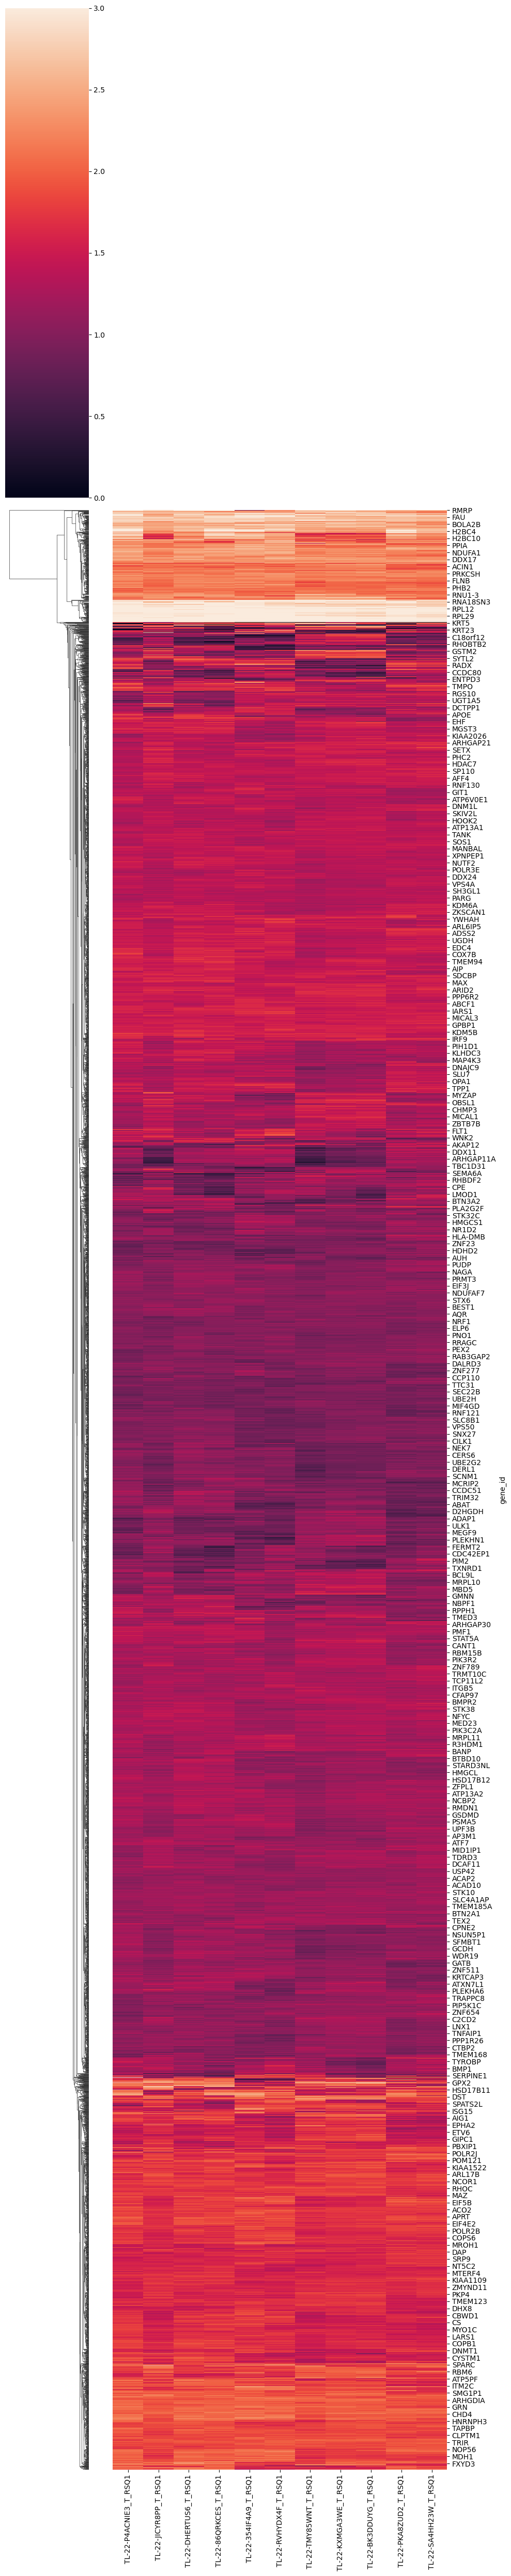

In [7]:
#remove genes with less than 10 reads averae for the heatmap, so less than 10 total
RNA_heatmapdf_LOG10 = RNA_heatmapdf_LOG10.loc[RNA_heatmapdf_LOG10.sum(axis = 1) > 10]
sns.clustermap(RNA_heatmapdf_LOG10, vmin = 0, vmax = 3, figsize=(10, 50), col_cluster = False)
plt.rcParams['savefig.bbox'] = 'tight'
plt.savefig('AllUTUCRNA_heatmap.png')
plt.savefig('AllUTUCRNA_heatmap.pdf')

In [16]:
#making percentages for figure 1
DNA_ordered_patient_list = ["TL-22-P4ACNIE3_T_DSQ1", "TL-22-JICYR8PP_T_DSQ1", "TL-22-DHERTUS6_T_DSQ1", "TL-22-86QRKCES_T_DSQ1", "TL-22-354IF4A9_T_DSQ1", "TL-22-RVHYDX4F_T_DSQ1", "TL-22-SKGMA3U8_T_DSQ1", "TL-22-KXMGA3WE_T_DSQ1", "TL-22-BK3DDUYG_T_DSQ1", "TL-22-PKA8ZUD2_T_DSQ1", "TL-22-SA4HH23W_T_DSQ1"]
sumofallmutations = len(pd.read_csv("DNA_data/freebayes_presorted_ALL_SAMPLES.bed", sep = "\t", names = ["chr", "pos", "end", "alt"]).drop_duplicates().index)
fig1_df = pd.DataFrame(columns = ["Number of mutations"])

for x in DNA_ordered_patient_list:
    fig1_df.loc[x, "Number of mutations"] = len(pd.read_csv("DNA_data/{}/filtered_freebayes_{}.bed".format(x,x), sep = "\t").index) + 1

fig1_df["Total number of mutations"] = sumofallmutations
fig1_df["pt1 mutations"] = len(pd.read_csv("DNA_data/pt1_freebayes_presorted_ALL_SAMPLES.bed", sep = "\t", names = ["chr", "pos", "end", "alt"]).drop_duplicates().index)
fig1_df["pt2 mutations"] = len(pd.read_csv("DNA_data/pt2_freebayes_presorted_ALL_SAMPLES.bed", sep = "\t", names = ["chr", "pos", "end", "alt"]).drop_duplicates().index)
fig1_df["pt3 mutations"] = len(pd.read_csv("DNA_data/pt3_freebayes_presorted_ALL_SAMPLES.bed", sep = "\t", names = ["chr", "pos", "end", "alt"]).drop_duplicates().index)
fig1_df["pt4 mutations"] = len(pd.read_csv("DNA_data/pt4_freebayes_presorted_ALL_SAMPLES.bed", sep = "\t", names = ["chr", "pos", "end", "alt"]).drop_duplicates().index)


fig1_df["% of all mutations"] = fig1_df["Number of mutations"]*100/fig1_df["Total number of mutations"]
fig1_df.loc["TL-22-P4ACNIE3_T_DSQ1", "% of patient mutations"] = fig1_df.loc["TL-22-P4ACNIE3_T_DSQ1", "Number of mutations"]*100/fig1_df.loc["TL-22-P4ACNIE3_T_DSQ1", "pt1 mutations"]
fig1_df.loc["TL-22-JICYR8PP_T_DSQ1", "% of patient mutations"] = fig1_df.loc["TL-22-JICYR8PP_T_DSQ1", "Number of mutations"]*100/fig1_df.loc["TL-22-JICYR8PP_T_DSQ1", "pt1 mutations"]
fig1_df.loc["TL-22-DHERTUS6_T_DSQ1", "% of patient mutations"] = fig1_df.loc["TL-22-DHERTUS6_T_DSQ1", "Number of mutations"]*100/fig1_df.loc["TL-22-DHERTUS6_T_DSQ1", "pt1 mutations"]
fig1_df.loc["TL-22-86QRKCES_T_DSQ1", "% of patient mutations"] = fig1_df.loc["TL-22-86QRKCES_T_DSQ1", "Number of mutations"]*100/fig1_df.loc["TL-22-86QRKCES_T_DSQ1", "pt1 mutations"]
fig1_df.loc["TL-22-354IF4A9_T_DSQ1", "% of patient mutations"] = fig1_df.loc["TL-22-354IF4A9_T_DSQ1", "Number of mutations"]*100/fig1_df.loc["TL-22-354IF4A9_T_DSQ1", "pt2 mutations"]
fig1_df.loc["TL-22-RVHYDX4F_T_DSQ1", "% of patient mutations"] = fig1_df.loc["TL-22-RVHYDX4F_T_DSQ1", "Number of mutations"]*100/fig1_df.loc["TL-22-RVHYDX4F_T_DSQ1", "pt2 mutations"]
fig1_df.loc["TL-22-SKGMA3U8_T_DSQ1", "% of patient mutations"] = fig1_df.loc["TL-22-SKGMA3U8_T_DSQ1", "Number of mutations"]*100/fig1_df.loc["TL-22-SKGMA3U8_T_DSQ1", "pt3 mutations"]
fig1_df.loc["TL-22-KXMGA3WE_T_DSQ1", "% of patient mutations"] = fig1_df.loc["TL-22-KXMGA3WE_T_DSQ1", "Number of mutations"]*100/fig1_df.loc["TL-22-KXMGA3WE_T_DSQ1", "pt3 mutations"]
fig1_df.loc["TL-22-BK3DDUYG_T_DSQ1", "% of patient mutations"] = fig1_df.loc["TL-22-BK3DDUYG_T_DSQ1", "Number of mutations"]*100/fig1_df.loc["TL-22-BK3DDUYG_T_DSQ1", "pt3 mutations"]
fig1_df.loc["TL-22-PKA8ZUD2_T_DSQ1", "% of patient mutations"] = fig1_df.loc["TL-22-PKA8ZUD2_T_DSQ1", "Number of mutations"]*100/fig1_df.loc["TL-22-PKA8ZUD2_T_DSQ1", "pt4 mutations"]
fig1_df.loc["TL-22-SA4HH23W_T_DSQ1", "% of patient mutations"] = fig1_df.loc["TL-22-SA4HH23W_T_DSQ1", "Number of mutations"]*100/fig1_df.loc["TL-22-SA4HH23W_T_DSQ1", "pt4 mutations"]



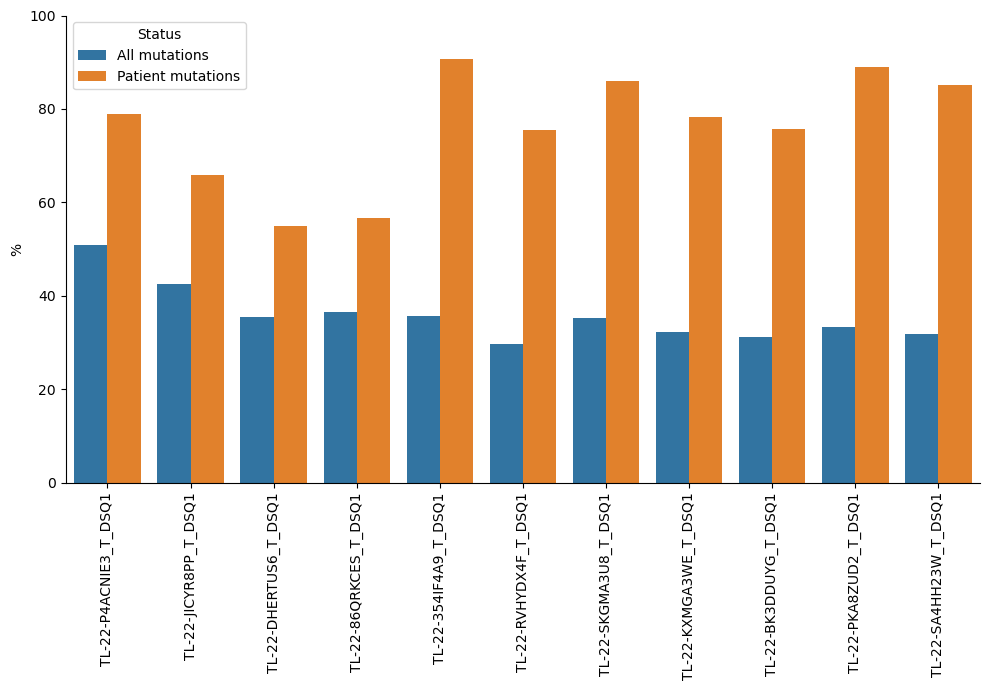

In [95]:
fig1_temp_df_1 = pd.DataFrame(fig1_df["% of all mutations"])
fig1_temp_df_1["Status"] = "All mutations"
fig1_temp_df_1.columns = ["%", "Status"]

fig1_temp_df_2 = pd.DataFrame(fig1_df["% of patient mutations"])
fig1_temp_df_2["Status"] = "Patient mutations"
fig1_temp_df_2.columns = ["%", "Status"]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
fig1_tempdf = pd.concat([fig1_temp_df_1, fig1_temp_df_2], axis = 0)
sns.barplot(data = fig1_tempdf, x = fig1_tempdf.index, y = fig1_tempdf["%"], hue = fig1_tempdf["Status"])
plt.xticks(rotation=90)
ax.set_ylim(0, 100)

plt.rcParams['savefig.bbox'] = 'tight'
plt.savefig('proposed_fig1.png')


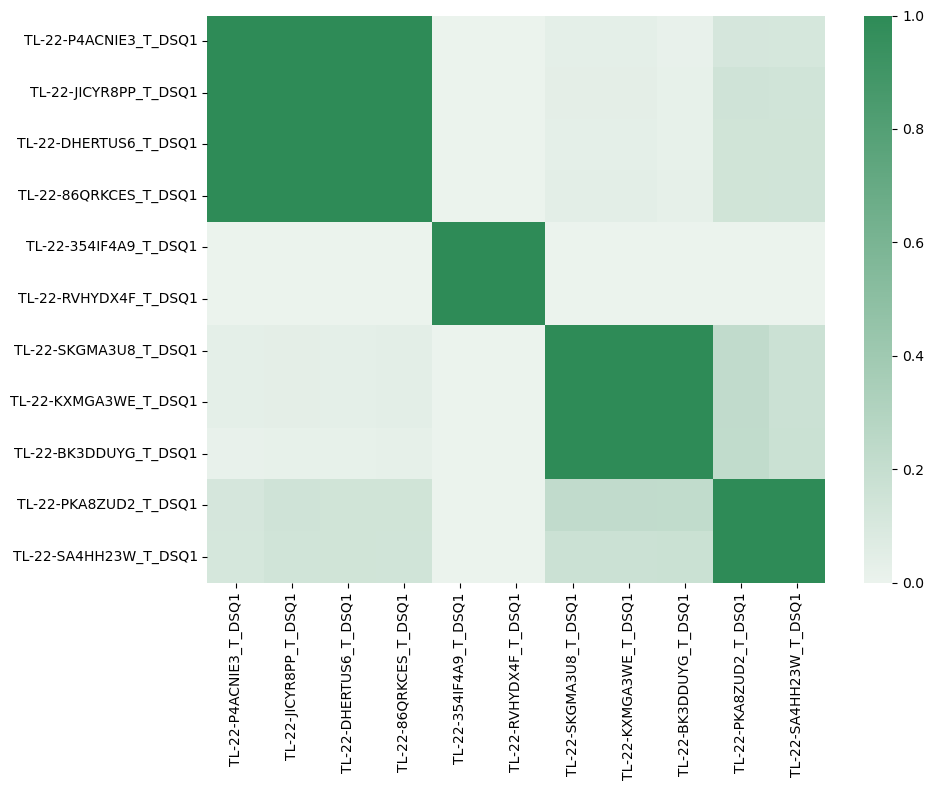

In [46]:
somalier_output = pd.read_csv("/intelpool/UTUCproject/DNA_data/somalier.pairs.tsv", sep = "\t")[["sample_a", "sample_b", "relatedness"]]
somalier_df = pd.DataFrame(index = DNA_ordered_patient_list, columns = DNA_ordered_patient_list)

for x in somalier_df.index:
    for y in somalier_df.columns:
        if (x == y):
            somalier_df.loc[x,y] = 1
        else:
            somalier_df.loc[x,y] = somalier_output.loc[(somalier_output["sample_a"] == x) & (somalier_output["sample_b"] == y) | (somalier_output["sample_a"] == y) & (somalier_output["sample_b"] == x)]["relatedness"].item()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))        
sns.heatmap(somalier_df.apply(pd.to_numeric, errors = "ignore"), cmap = sns.light_palette("seagreen", as_cmap=True), vmin = 0)
plt.savefig('fig1_heatmap.png')
